In [1]:
using Pkg
#Pkg.add("RigidBodyDynamics")
#Pkg.add("MeshCat")
#Pkg.add("MeshCatMechanisms")
#Pkg.add("StaticArrays")
#Pkg.add("Rotations")
#Pkg.add("ForwardDiff")
#Pkg.add("FiniteDiff")
#Pkg.add("Quaternions")
#Pkg.add("OSQP")
#Pkg.add("Plots")
#Pkg.add("Colors")
#Pkg.add("MathOptInterface")
#Pkg.add("Ipopt")
#Pkg.add("GeometryBasics")
#Pkg.add("CoordinateTransformations")
#Pkg.add("Optim")
include(joinpath(@__DIR__, "humanoid.jl"))
include(joinpath(@__DIR__, "ball_qp.jl"))
include(joinpath(@__DIR__, "../src/utils/fmincon.jl"))
using LinearAlgebra
import ForwardDiff as FD
using GeometryBasics
#using Optim

WebIO._IJuliaInit()

## Finding Robot Balancing Pose

In [2]:
model = G1Humanoid()
mech = model.mech
# note: state is [q, dq], (q is in continous time, rad/s)
const x_guess = initial_state(model) # our guess state for balancing
mvis = initialize_visualizer(model) # visualizer 
set_configuration!(mvis, x_guess[1:state_dim(model)÷2])
foot_pos = get_right_foot_tip_location(mech, x_guess)
println("Foot tip position: ", foot_pos)

# Add red sphere at foot location
foot_point = mvis.visualizer["foot_point"]
setobject!(
    foot_point, 
    HyperSphere(Point3f(foot_pos), Float32(0.01))  # Both Float32
)
setprop!(foot_point, "color", RGB(1, 0, 0))  # Red color
render(mvis)

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


Foot tip position: [-0.4539735038572158, -0.19194453008619367, 0.2135702686910089]


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("foot_point" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74], nothing, Dict{String, Vector{UInt8}}("color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_roll_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_8" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_hip_yaw_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x5f, 0x79, 0x61, 0x77, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("

In [5]:
lower_limits = [
    -0.2618, -0.87267, -0.087267, -2.7576, -0.5236, 
    -2.5307, -2.5307, -2.618, -2.9671, -0.52, 
    -2.7576, -0.52, -0.087267, -3.0892, -3.0892,
    -0.87267, -1.5882, -2.2515, -0.2618, -2.618, 
    -2.618, -1.0472, -1.0472, -1.9722, -1.9722,
    -1.6144, -1.6144, -1.6144, -1.6144
]

upper_limits = [
    0.2618, 0.5236, 2.8798,  2.7576, 2.9671, 
    2.8798, 2.8798, 2.618,  0.5236, 0.52,
    2.7576, 0.52, 2.8798, 2.6704, 2.6704,
    0.5236, 2.2515, 1.5882, 0.2618, 2.618,
    2.618, 2.0944, 2.0944, 1.9722, 1.9722, 
    1.6144, 1.6144, 1.6144, 1.6144
];

In [6]:
function dynamics_constraint(params::NamedTuple, Z::Vector)::Vector
    idx_x, idx_u, model = params.idx_x, params.idx_u, params.model
    return dynamics(model, Z[idx_x], Z[idx_u])
end

function cost(params::NamedTuple, Z::Vector)::Real
    idx_x, idx_u, x_guess = params.idx_x, params.idx_u, params.x_guess
    return 1/2 * (Z[idx_x] - x_guess)' * (Z[idx_x] - x_guess) + 1/2 * 1e-5 * Z[idx_u]' * Z[idx_u]
end

c_l = zeros(0)
c_u = zeros(0)
function inequality_constraint(params, Z)
    return zeros(eltype(Z), 0)
end

nx = 58
nu = 29
idx_x = 1:58
idx_u = 59:87

params = (
        nx=nx,
        nu=nu,
        idx_x=idx_x,
        idx_u=idx_u,
        model=model,
        x_guess=x_guess
        )

x_l = -120 * ones(nx + nu)
x_u = 120 * ones(nx + nu)

x_l[1:29] .= lower_limits
x_u[1:29] .= upper_limits

z0 = vcat(x_guess, 0.01 * randn(nu))
verbose = false
#diff_type = :auto 
diff_type = :finite
Z = fmincon(cost,dynamics_constraint,inequality_constraint,
        x_l,x_u,c_l,c_u,z0,params, diff_type;
        tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)

set_configuration!(mvis, Z[1:state_dim(model)÷2])
u_eq = Z[idx_u]
x_eq = Z[idx_x]
x_dot = dynamics(model, x_eq, u_eq)
@assert norm(x_dot, Inf) < 1e-6
foot_equilib_pos = get_right_foot_tip_location(mech, x_eq)
println(foot_equilib_pos)
println("Equilibrium found! $(norm(x_dot, Inf))")
open(mvis)
render(mvis)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[-0.4482449268932769, -0.18853834852593343, 0.2455812826965415]
Equilibrium found! 4.614285426338846e-10


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("foot_point" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74], nothing, Dict{String, Vector{UInt8}}("color" => [0x84, 0xa8, 0x70, 0x72, 0x6f, 0x70, 0x65, 0x72, 0x74, 0x79  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x70, 0x6f, 0x69, 0x6e, 0x74]), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_roll_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_8" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_hip_yaw_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x5f, 0x79, 0x61, 0x77, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("

In [7]:
x_max = norm(x_eq, Inf)
u_max = norm(u_eq, Inf)
println(x_max)
println(u_max)
save("equilibrium.jld2", "x", x_eq, "u", u_eq)

1.396961772068141
21.08274611653724


# IHLQR

In [2]:
dt = 0.02
function rk4(model, x, u, dt)
    k1 = dt * dynamics(model, x, u)
    k2 = dt * dynamics(model, x .+ k1/2, u)
    k3 = dt * dynamics(model, x .+ k2/2, u)
    k4 = dt * dynamics(model, x .+ k3, u)
    return x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
end

function ihlqr(A::Matrix,B::Matrix,Q::Matrix,R::Matrix; max_iter = 10000,tol = 1e-5)::Tuple{Matrix, Matrix} 
    nx, nu = size(B)
    P = deepcopy(Q)
    for riccati_iter = 1:max_iter 
        K = (R + B'*P*B)\(B'*P*A)
        P_next = Q + A'*P*(A - B * K)
        if norm(P_next - P) <= tol
            return P_next, K
        end
        P = P_next
    end
    error("ihlqr did not converge")
end

ihlqr (generic function with 1 method)

## Ball Dynamics, Calculating Kick Point

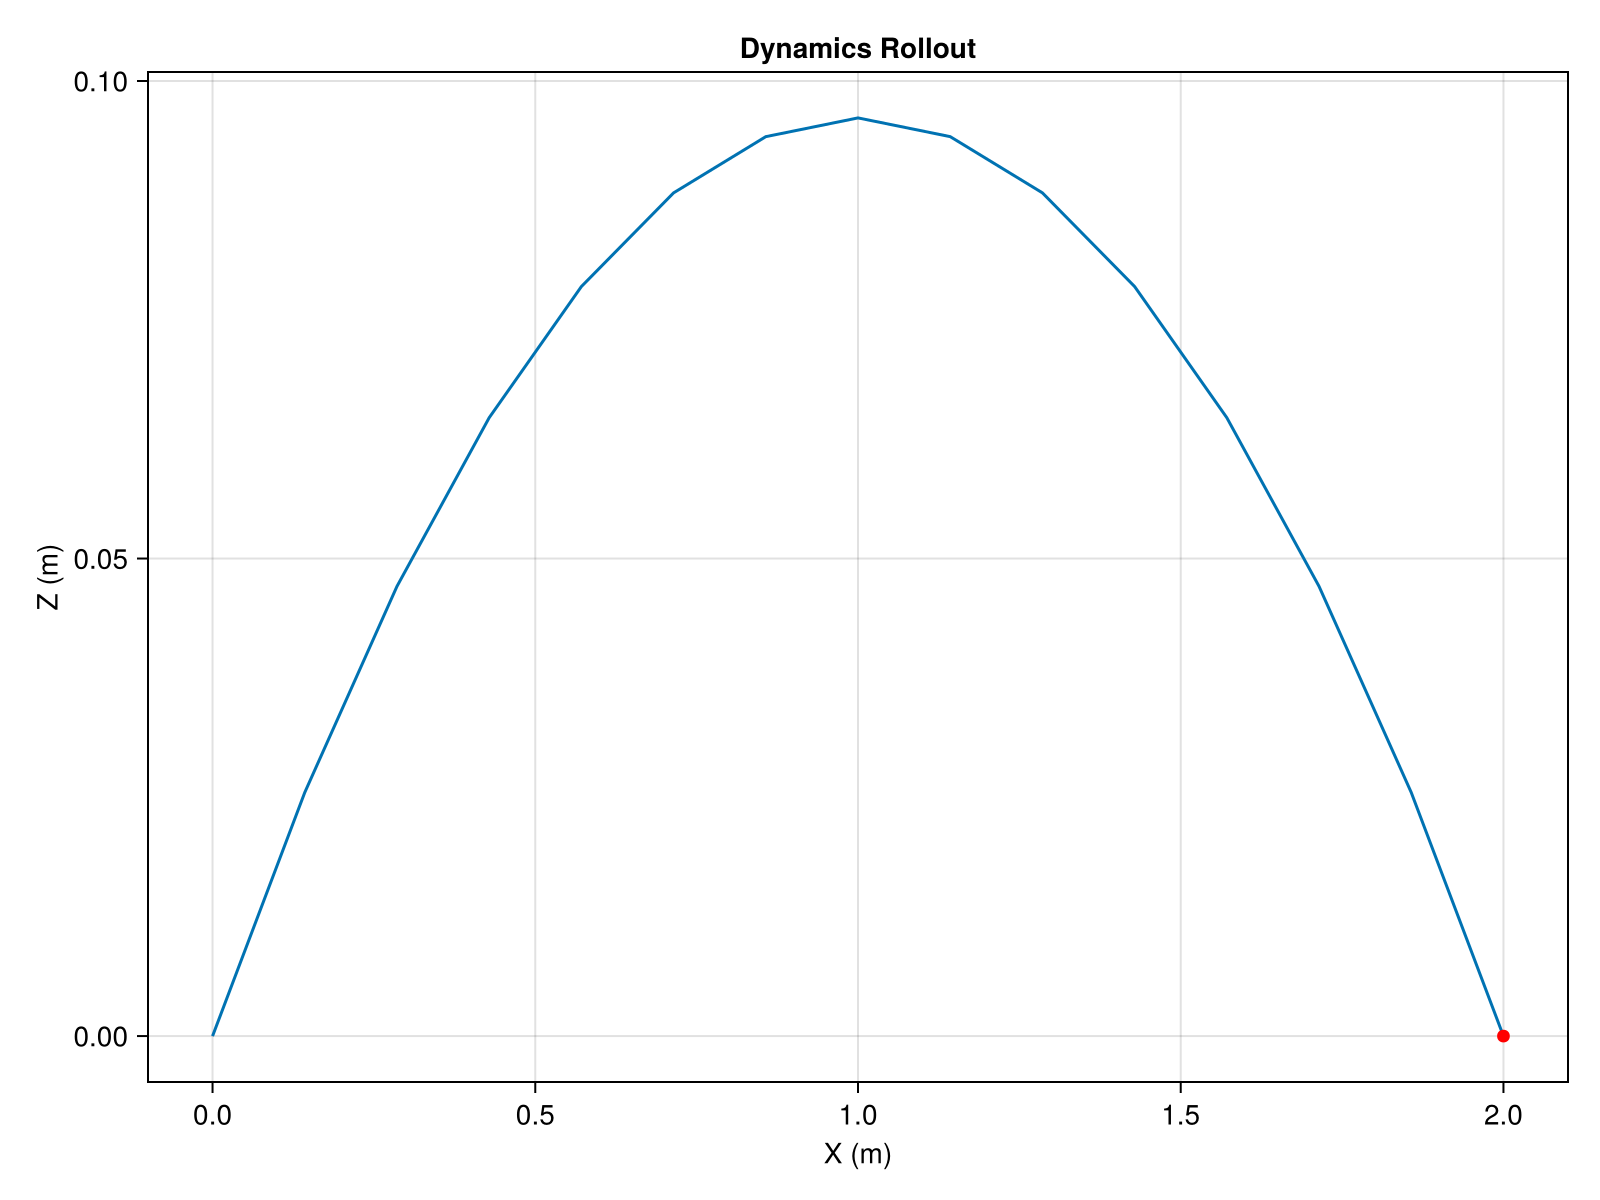

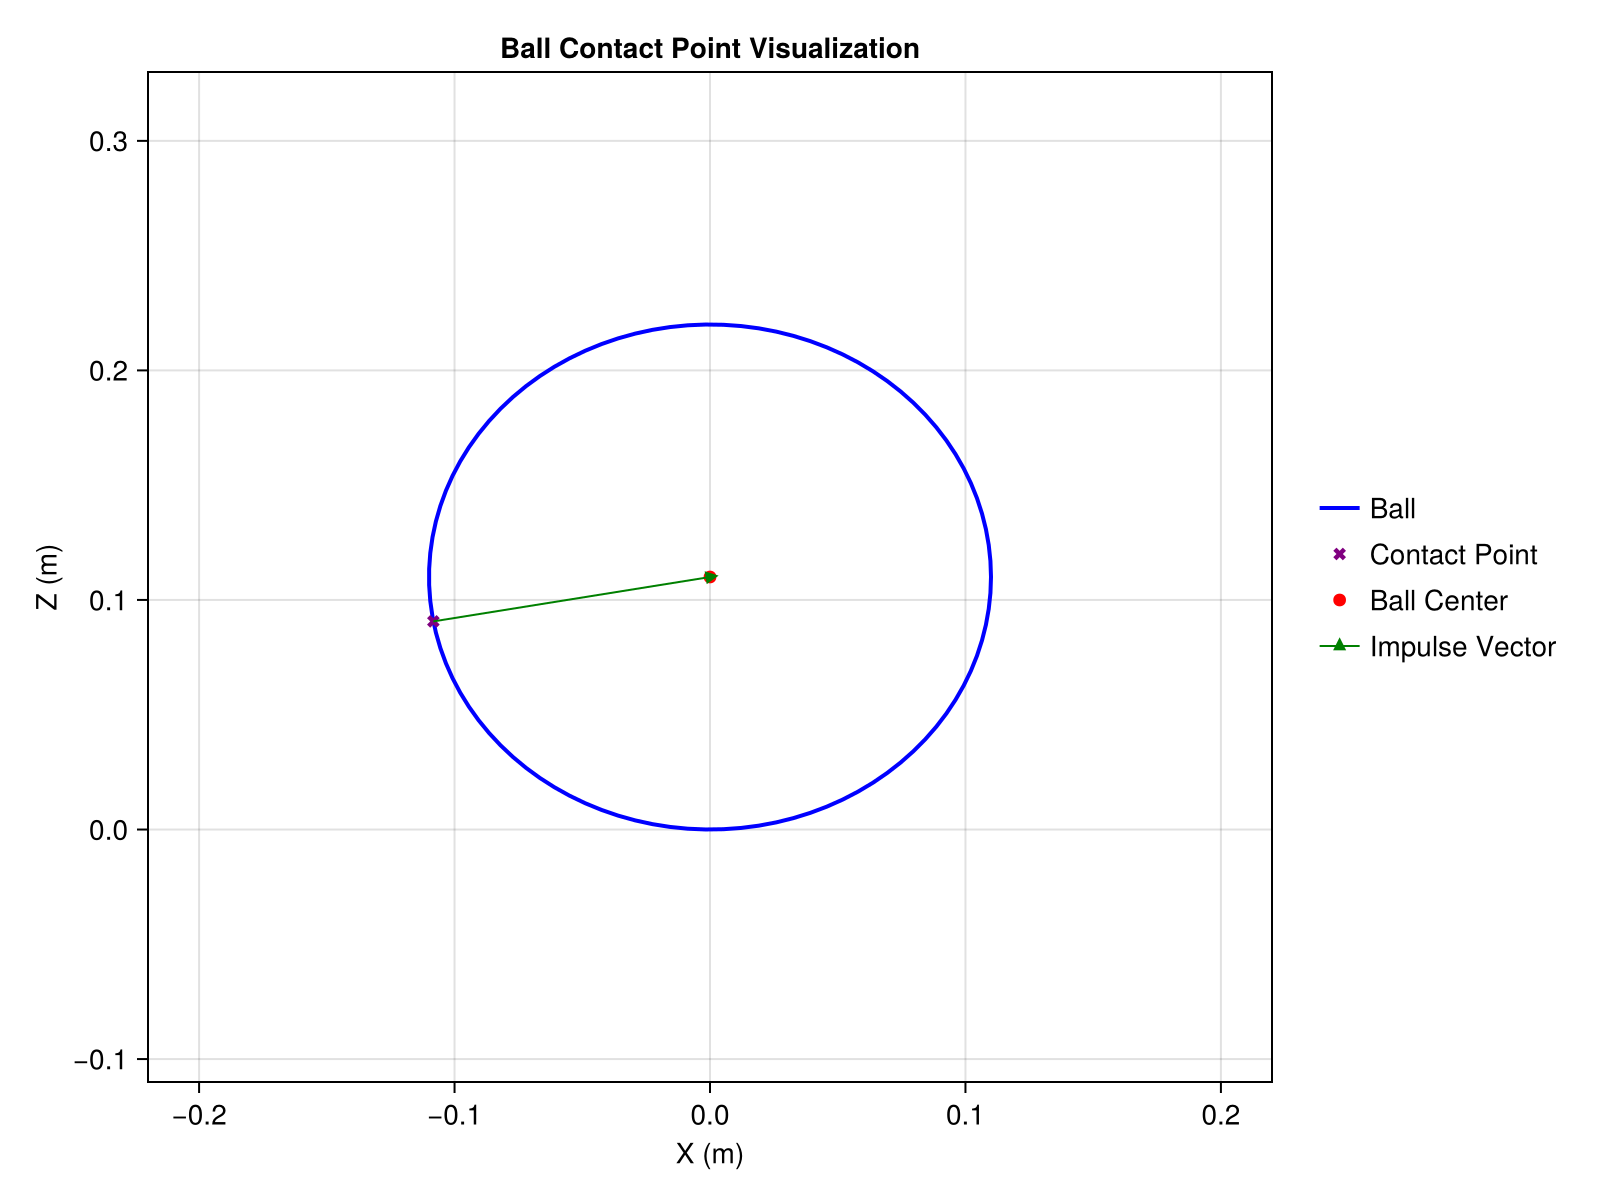

[0.09171241526115889, -0.13, 0.09066611804555783]
[7.142857144989617, 0.0, 1.275300000380736]

In [9]:
q_i = [0.0, 0.0] # Note, this is in the X-Z Plane only, y value will be assigned manually after the fact
q_des = [2.0, 0.0]
J_max = Inf
ball_flight_steps = 15
m = 0.1
dt=0.02
J = optimize_impulse(q_des, q_i, N=ball_flight_steps, J_max=J_max, dt=dt, m=m) # Can also specify mass
dynamics_rollout(J, q_des, q_i, N=ball_flight_steps, dt=dt, m=m)
p_c = get_contact_point(J) # Can also specify radius of ball
visualize_contact(J, p_c)
p_c = [p_c[1] + 0.2, -0.13, p_c[2]] # accounting for ball being placed forward
println(p_c)
v_des = J / m
v_des = [v_des[1], 0, v_des[2]]
print(v_des)

## Solve For Initial Guess

In [9]:
function generate_kick_arc_trajectory(
    start_pos::Vector{Float64},
    end_pos::Vector{Float64},
    arc_dip::Float64,
    arc_rise::Float64,
    max_step_norm::Float64;
    max_points::Int = 500,
    scale_dip_if_needed::Bool = true
)
    num_points = 2
    orig_dip = arc_dip  # Save original for scaling logic

    function create_kick_arc(n, dip)
        arc_traj = Vector{SVector{3, Float64}}()
        for i in range(0, 1, length=n)
            pos = (1 - i) * start_pos .+ i * end_pos

            if i < 0.5
                z_mod = -4 * dip * i * (1 - i)
            else
                z_mod = 2 * arc_rise * (i - 0.5)^2
            end

            pos[3] += z_mod
            push!(arc_traj, SVector{3}(pos))
        end
        return arc_traj
    end

    while num_points <= max_points
        arc = create_kick_arc(num_points, arc_dip)
        max_dist = maximum(norm(arc[i+1] - arc[i]) for i in 1:length(arc)-1)

        if max_dist < max_step_norm
            return arc
        end

        # Optional: adaptive dip scaling
        if scale_dip_if_needed && num_points == max_points
            arc_dip *= 0.95  # reduce dip a bit
            num_points = 2   # restart with fewer points
            #@info "Reducing dip to $(round(arc_dip, digits=4)) to meet step constraint."
        else
            num_points += 1
        end
    end

    error("Could not satisfy step constraint after $max_points points. Final dip = $(round(arc_dip, digits=4))")
end




# Example inputs
equilib_foot_pos = [-0.3697416851162835, -0.1812921683831133, 0.28428794901541954]
goal_foot_pos = p_c

kick_arc = generate_kick_arc_trajectory(
    equilib_foot_pos, 
    goal_foot_pos, 
    0.05,   
    0.01,
    0.02
)

if kick_arc[size(kick_arc, 1)] != goal_foot_pos
    push!(kick_arc, goal_foot_pos)
end

if kick_arc[1] == equilib_foot_pos
    popfirst!(kick_arc)
end
# Print the resulting arc
for pos in kick_arc
    println(pos)
end

[-0.35759815615898244, -0.17994237447829453, 0.27704991573461857]
[-0.34545462720168135, -0.17859258057347577, 0.2699277052613575]
[-0.3333110982443802, -0.17724278666865698, 0.2629213175956363]
[-0.321167569287079, -0.1758929927638382, 0.2560307527374551]
[-0.3090240403297779, -0.17454319885901945, 0.24925601068681388]
[-0.2968805113724768, -0.17319340495420066, 0.24259709144371253]
[-0.2847369824151757, -0.1718436110493819, 0.23605399500815116]
[-0.2725934534578746, -0.17049381714456313, 0.22962672138012974]
[-0.2604499245005735, -0.16914402323974437, 0.22331527055964825]
[-0.2483063955432724, -0.1677942293349256, 0.2171196425467067]
[-0.23616286658597127, -0.1664444354301068, 0.21103983734130505]
[-0.22401933762867013, -0.16509464152528805, 0.20507585494344338]
[-0.21187580867136901, -0.16374484762046929, 0.19922769535312163]
[-0.19973227971406787, -0.1623950537156505, 0.1934953585703398]
[-0.1875887507567668, -0.16104525981083173, 0.18787884459509796]
[-0.1754452217994657, -0.15969

In [13]:
states = Vector{Vector{Float64}}(undef, length(kick_arc)+1)
states[1] = x_eq
inputs = Vector{Vector{Float64}}(undef, length(kick_arc)+1)
inputs[1] = u_eq
k = 2

nx = 58
nu = 29

x_curr = x_eq
u_curr = u_eq
idx_x = 1:58
idx_u = 59:87

x_l = -120 * ones(nx + nu)
x_u = 120 * ones(nx + nu)

x_l[1:29] .= lower_limits
x_u[1:29] .= upper_limits

for desired_foot_pos in kick_arc
    function equality_constraints(params::NamedTuple, Z::Vector)::Vector
        idx_x, idx_u, model = params.idx_x, params.idx_u, params.model
        kick_constraint = get_right_foot_tip_location(model.mech, Z[idx_x]) - params.desired_foot_pos

        return [dynamics_constraint(params, Z); kick_constraint]
    end

    params = (
        nx=nx,
        nu=nu,
        idx_x=idx_x,
        idx_u=idx_u,
        model=model,
        x_guess=x_curr,
        desired_foot_pos=desired_foot_pos
        )

    z0 = vcat(x_curr, u_curr)
    verbose = false
    diff_type = :finite
    println("Solving timestep $(k) with foot position $(desired_foot_pos)")
    Z = fmincon(cost,equality_constraints,inequality_constraint,
        x_l,x_u,c_l,c_u,z0,params, diff_type;
        tol = 1e-3, c_tol = 1e-3, max_iters = 10_000, verbose = verbose)
    states[k] = Z[idx_x]
    inputs[k] = Z[idx_u]
    k += 1
    x_curr = Z[idx_x]
    u_curr = Z[idx_u]
end


Solving timestep 2 with foot position [-0.35759815615898244, -0.17994237447829453, 0.27704991573461857]
Solving timestep 3 with foot position [-0.34545462720168135, -0.17859258057347577, 0.2699277052613575]
Solving timestep 4 with foot position [-0.3333110982443802, -0.17724278666865698, 0.2629213175956363]
Solving timestep 5 with foot position [-0.321167569287079, -0.1758929927638382, 0.2560307527374551]
Solving timestep 6 with foot position [-0.3090240403297779, -0.17454319885901945, 0.24925601068681388]
Solving timestep 7 with foot position [-0.2968805113724768, -0.17319340495420066, 0.24259709144371253]
Solving timestep 8 with foot position [-0.2847369824151757, -0.1718436110493819, 0.23605399500815116]
Solving timestep 9 with foot position [-0.2725934534578746, -0.17049381714456313, 0.22962672138012974]
Solving timestep 10 with foot position [-0.2604499245005735, -0.16914402323974437, 0.22331527055964825]
Solving timestep 11 with foot position [-0.2483063955432724, -0.167794229334

In [14]:
mvis = initialize_visualizer(model) # visualizer
open(mvis)
dt = 0.02
for k = 1:length(states)
    q = states[k]
    v = zeros(length(q))              # zero velocities
    full_state = [q; v]               # concatenate position and velocity
    set_configuration!(mvis, full_state[1:state_dim(model)÷2])
    sleep(dt*5)
    render(mvis)
end

[ Info: Listening on: 127.0.0.1:8762, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8762


In [15]:
x_g = states[end]
u_g = inputs[end]
for k = 1:length(kick_arc)
    -1
    states[k][30:58] = (states[k+1][1:29] - states[k][1:29]) / dt
end

nv = 32

window_size = 3
states[end][30:58] = states[end-1][30:58]
for i in 1:length(kick_arc)
    count = 0
    for j in max(1, i - window_size):min(length(kick_arc), i + window_size)
        states[i][30:58] .+= states[j][30:58]
        count += 1
    end
    states[i][30:58] ./= count
end
save("guess.jld2", "x", states, "x_g", x_g, "u_g", u_g)

## Calculating Kick Trajectory

In [3]:
using Pkg

#Pkg.add("NamedTrajectories")
#Pkg.add("CairoMakie")
#Pkg.add("BenchmarkTools")
#Pkg.add(url="https://github.com/kevin-tracy/lazy_nlp_qd.jl.git")
#Pkg.add("ProgressMeter")
using NamedTrajectories
using CairoMakie
using BenchmarkTools
import ForwardDiff as FD
using LinearAlgebra
using Plots
using lazy_nlp_qd
#import MeshCat as mc
using StaticArrays
using ProgressMeter
using FileIO
using Optim
include(joinpath(@__DIR__, "../src/utils/utils.jl"))
include(joinpath(@__DIR__, "../src/utils/nlp_utils.jl"))

constraint_violation (generic function with 1 method)

In [4]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u)::Vector
    model = params.model
    dt = params.dt
    x1dot = dynamics(model, x1, u)
    x2dot = dynamics(model, x2, u)
    x_k12 = 1/2 * (x1 + x2) + dt/8 * (x1dot - x2dot)
    return x1 + dt/6 * (x1dot + 4 * dynamics(model, x_k12, u) + x2dot) - x2
end

hermite_simpson (generic function with 1 method)

In [5]:
function quadratic_cost(traj_indices::NamedTuple, k::Int64, Q::Matrix{Float64}, R::Matrix{Float64}, x_eq)
    xi, ui = traj_indices.x[k], traj_indices.u[k]
    # TODO: Tune this cost function -> add costs related to foot position
    function cost_func(params::NamedTuple, z::Vector)
        x = z[xi]
        return 0.5*(x[1:29] - x_eq[1:29])'*Q*(x[1:29] - x_eq[1:29]) + 0.5 * z[ui]'*R*z[ui] #+ foot_pos_cost

    end
    function cost_grad!(params::NamedTuple, z::Vector{Float64}, grad::Vector{Float64})
        grad .+= FD.gradient(z_ -> cost_func(params, z_), z)
    end
    return (cost_func=cost_func, cost_grad=cost_grad!)
end

function final_cost(traj_indices::NamedTuple, N::Int64, Qf::Matrix{Float64}, x_g)
    xi = traj_indices.x[N]
    cost_func(params::NamedTuple, z::Vector) = 0.5*((z[xi][1:29] - x_g[1:29])'*Qf*(z[xi][1:29] - x_g[1:29]))
    function cost_grad!(params::NamedTuple, z::Vector{Float64}, grad::Vector{Float64})
        grad .+= FD.gradient(z_ -> cost_func(params, z_), z)
    end
    return (cost_func=cost_func, cost_grad=cost_grad!)
end

# Dynamics Constraints
function dyn_constraint(traj_indices::NamedTuple, k::Int64)
    xi, ui, next_xi = traj_indices.x[k], traj_indices.u[k], traj_indices.x[k+1]
    nx = 58
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= hermite_simpson(params, z[xi], z[next_xi], z[ui])
    
    function jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix)
        x_k, u_k, next_x_k = z[xi], z[ui], z[next_xi]
        conjac[:, xi] = FD.jacobian(x_ -> hermite_simpson(params, x_, next_x_k, u_k), x_k);
        conjac[:, ui] = FD.jacobian(u_ -> hermite_simpson(params, x_k, next_x_k, u_), u_k);
        conjac[:, next_xi] = FD.jacobian(x_ -> hermite_simpson(params, x_k, x_, u_k), next_x_k);
        return nothing
    end
    function sparsity!(conjac::AbstractMatrix)
        conjac[:, xi] .= 1;
        conjac[:, ui] .= 1;
        conjac[:, next_xi] .= 1;
        return nothing
    end
    bounds = (zeros(nx), zeros(nx))
    return (length=nx, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

# State Intial Condition Constraint
function ic_constraint(traj_indices::NamedTuple, x_ic::Vector{Float64})
    x0 = traj_indices.x[1]
    nx = 58
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= z[x0] - x_ic
    jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = conjac[:, x0] = I(length(x_ic))
    sparsity!(conjac::AbstractMatrix) = conjac[:, x0] .= 1
    bounds = (zeros(nx), zeros(nx))
    return (length=nx, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

# State Goal Condition Constraint
function goal_constraint(traj_indices::NamedTuple, x_g::Vector{Float64}, N)
    x_N = traj_indices.x[N]
    nx = 58
    nq = 29
    residual(params::NamedTuple, z::Vector, con::AbstractVector) = con .= z[x_N][1:29] - x_g[1:29]
    jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = conjac[:, x_N[1:29]] = I(length(x_N[1:29]))
    sparsity!(conjac::AbstractMatrix) = conjac[:, x_N[1:29]] .= 1

    bounds = (zeros(nq), zeros(nq))
    # bounds = (zeros(nx), zeros(nx))

    return (length=nq, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

function foot_velocity_constraint(traj_indices::NamedTuple, mech::Mechanism, v_des, N)
    xi = traj_indices.x[N]
    foot_body = findbody(model.mech, "right_ankle_roll_link")
    world_body = findbody(model.mech, "world")
    kinematic_path = path(model.mech, foot_body, world_body)

    residual(params::NamedTuple, z::Vector, con::AbstractVector) = begin
        J = FD.jacobian(x_ -> get_right_foot_tip_location(model.mech, x_), z[xi])
        dq = z[xi[30:58]]
        con .= J[:, 1:29]*dq - v_des
    end

   jacobian!(params::NamedTuple, z::Vector, conjac::AbstractMatrix) = begin
        J = FD.jacobian(x_ -> get_right_foot_tip_location(model.mech, x_), z[xi])
        conjac[:, xi[30:58]] .= J[:, 1:29]
    end
    
    
    sparsity!(conjac::AbstractMatrix) = conjac[:, xi] .= 1
    bounds = (zeros(3), zeros(3))
    
    return (length=3, residual=residual, jacobian=jacobian!, sparsity=sparsity!, bounds=bounds)
end

foot_velocity_constraint (generic function with 1 method)

In [6]:
function optimize_trajectory_sparse(nx, nu, dt, N, x_eq, u_eq, equilib_foot_pos, kick_foot_pos, model, lower_joint_limits, upper_joint_limits, x_guess, u_guess, x_g, v_g)
    nq = 29
    Q = diagm(1e-1*ones(nq)) # only care about position, not velocity
    R = diagm(1e-3*ones(nu))
    Qf = diagm(1e3*ones(nq))
    x_ic = 1 * x_eq
    components = (
        x = rand(nx, N),
        u = rand(nu, N),
    )

    z0 = vcat(
        [vcat(x_guess[i], u_guess[i]) for i in 1:N]...
    )

    traj = NamedTrajectory(components; timestep=dt, controls=:u)
    traj_indices = NamedTuple{traj.names}([[(k - 1)*traj.dim .+ getproperty(traj.components, symbol) for k in 1:traj.T] for symbol in traj.names])
    cost_objs = vcat(
        [quadratic_cost(traj_indices, k, Q, R, x_eq) for k = 1:N-1], # change to x_eq for now to test
        final_cost(traj_indices, N, Qf, x_g)
    )

    # TODO: expirement with constraints to limit the wiggle of the foot
    con_objs = Vector{NamedTuple}([foot_velocity_constraint(traj_indices, model.mech, v_g, N), ic_constraint(traj_indices, x_ic), goal_constraint(traj_indices, x_g, N), [dyn_constraint(traj_indices, k) for k = 1:N-1]...])
    nc, conjac = setup_constraints(traj, con_objs)

    param = (costs = cost_objs, constraints = con_objs, nconstraints=nc, nz=length(traj.datavec), model=model, dt=dt)
    @assert nc < length(traj.datavec)
    # Constrain bounds (equality and inequality)
    c_l, c_u = constraint_bounds(param)


    # primal bounds TODO: tighten these to get desired behaviour
    z_l, z_u = fill(-120.0, param.nz), fill(120.0, param.nz)

    # bound foot rotation to be zero
    for k = 1:N
        xi = traj_indices.x[k]
        ui = traj_indices.u[k]
        z_l[xi[1:29]] .= 1 .* lower_joint_limits # TODO: these joint limits seem to be the limiting constraints
        z_u[xi[1:29]] .= 1 .* upper_joint_limits
        z_l[xi[30:58]] .= -15
        z_u[xi[30:58]] .= 15
    end

    z = lazy_nlp_qd.sparse_fmincon(cost_func,
                                cost_gradient!,
                                constraint_residual!,
                                constraint_jacobian!,
                                conjac,
                                z_l,
                                z_u, 
                                c_l,
                                c_u,
                                z0,
                                param,
                                tol = 1e-4, # for testing purposes
                                c_tol = 1e-10, # for testing purposes
                                max_iters = 1000,
                                print_level = 5); # for testing purposes
    traj.datavec .= z
    save("trajectory.jld2", "traj", traj, "traj_indices", traj_indices)

    return traj
end

optimize_trajectory_sparse (generic function with 1 method)

In [7]:
equilib_loaded = load("equilibrium.jld2")
x_eq = equilib_loaded["x"]
u_eq = equilib_loaded["u"]
guess_loaded = load("guess.jld2")
x_init = guess_loaded["x"]
lower_limits = [
    -0.2618, -0.87267, -0.087267, -2.7576, -0.5236, 
    -2.5307, -2.5307, -2.618, -2.9671, -0.52, 
    -2.7576, -0.52, -0.087267, -3.0892, -3.0892,
    -0.87267, -1.5882, -2.2515, -0.2618, -2.618, 
    -2.618, -1.0472, -1.0472, -1.9722, -1.9722,
    -1.6144, -1.6144, -1.6144, -1.6144
]

upper_limits = [
    0.2618, 0.5236, 2.8798,  2.7576, 2.9671, 
    2.8798, 2.8798, 2.618,  0.5236, 0.52,
    2.7576, 0.52, 2.8798, 2.6704, 2.6704,
    0.5236, 2.2515, 1.5882, 0.2618, 2.618,
    2.618, 2.0944, 2.0944, 1.9722, 1.9722, 
    1.6144, 1.6144, 1.6144, 1.6144
];

In [ ]:
model = G1Humanoid()
mech = model.mech
nx, nu, dt, N = size(x_eq, 1), size(u_eq, 1), 0.02, length(x_init)

equilib_foot_pos = [-0.3697416851162835, -0.1812921683831133, 0.28428794901541954]
goal_foot_pos = p_c
u_init = [0.05 * rand(nu) for k=1:length(x_init)]
x_g = x_init[end]
v_g = v_des

traj = optimize_trajectory_sparse(nx, nu, dt, N, x_eq, u_eq, equilib_foot_pos, goal_foot_pos, model, lower_limits, upper_limits, x_init, u_init, x_g, v_g);


# Visualizing Results
### Assumption Mfoot >> Mball

In [4]:
loaded = load("trajectory.jld2")
traj = loaded["traj"]
traj_indices = loaded["traj_indices"];

equilib_loaded = load("equilibrium.jld2")
x_eq = equilib_loaded["x"]
u_eq = equilib_loaded["u"]
guess_loaded = load("guess.jld2")
x_g = guess_loaded["x_g"]
u_g = guess_loaded["u_g"]
model = G1Humanoid();

In [5]:
function rk4(model::G1Humanoid, x::Vector, u::Vector, dt::Real)::Vector
    k1 = dt * dynamics(model, x, u)
    k2 = dt * dynamics(model, x + 0.5 * k1, u)
    k3 = dt * dynamics(model, x + 0.5 * k2, u)
    k4 = dt * dynamics(model, x + k3, u)
    xp1 = x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
    return xp1
end

function ball_dynamics(x, dt) # rk4 for the ball
    function dyn(x)
        g = [0; 0; 9.81]
        q = x[1:3]
        v = x[4:6]
        dq = v
        dv = -g
        return [dq; dv]
    end
    k1 = dt * dyn(x)
    k2 = dt * dyn(x + 0.5 * k1)
    k3 = dt * dyn(x + 0.5 * k2)
    k4 = dt * dyn(x + k3)
    return x + (1/6) * (k1 + 2*k2 + 2*k3 + k4)
end


function animate_humanoid_kick(Xh, Xb, model, dt)
    # Initialize visualizer pair correctly
    mvis = initialize_visualizer(model)  # This should return both mvis AND vis
    vis = mvis.visualizer  # Extract from initialized visualizer
    open(mvis)
    # Use mvis's visualizer for all objects
    setobject!(vis["ball"], 
        GeometryBasics.HyperSphere{3, Float32}(Point3f(0,0,0), 0.11),
        MeshPhongMaterial(color=RGBA(1,0,0,1)))
    
    fps = floor(Int, 1/dt)
    anim = MeshCat.Animation(vis, fps=fps)

    for k in 1:length(Xh)
        atframe(anim, k) do
            set_configuration!(mvis, Xh[k][1:29])
            
            settransform!(vis["ball"], Translation(SVector{3}(Xb[k][1:3])))

        end
    end

    setanimation!(vis, anim)
    return render(vis)
end


animate_humanoid_kick (generic function with 1 method)

In [8]:
dt = 0.02
A = FD.jacobian(x_ -> rk4(model, x_, u_eq, dt), x_eq)
B = FD.jacobian(u_ -> rk4(model, x_eq, u_, dt), u_eq)

Q = diagm(1e0*ones(length(x_eq)))
R = diagm(1e-3*ones(length(u_eq)))
Qf = diagm(1e3*ones(length(x_eq)))
_,Keq = ihlqr(A, B, Q, R);

A = FD.jacobian(x_ -> rk4(model, x_, u_g, dt), x_g)
B = FD.jacobian(u_ -> rk4(model, x_g, u_, dt), u_g)

R = diagm(1e-3*ones(length(u_eq)))
_,Kg = ihlqr(A, B, Q, R);

nx = length(traj.datavec[traj_indices.x[1]])
nu = length(traj.datavec[traj_indices.u[1]])
N = length(traj_indices.x)
P = [zeros(nx,nx) for i = 1:N]
Ktv = [zeros(nu,nx) for i = 1:N-1]
P[N] = deepcopy(Qf)

for k = (N-1):-1:1 # TVLQR -> linearize around each timestep, use this in ricatti recursion till you reach start
    X = traj.datavec[traj_indices.x[k]]
    U = traj.datavec[traj_indices.u[k]]
    A = FD.jacobian(x_ -> rk4(model, x_, U, dt), X)
    B = FD.jacobian(u_ -> rk4(model, X, u_, dt), U)
    Ktv[k] = (R + B'*P[k+1]*B)\(B'*P[k+1]*A)
    P[k] = Q + A'*P[k+1]*(A-B*Ktv[k])
end

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie C:\Users\Obert\.julia\packages\Makie\ux0Te\src\scenes.jl:238


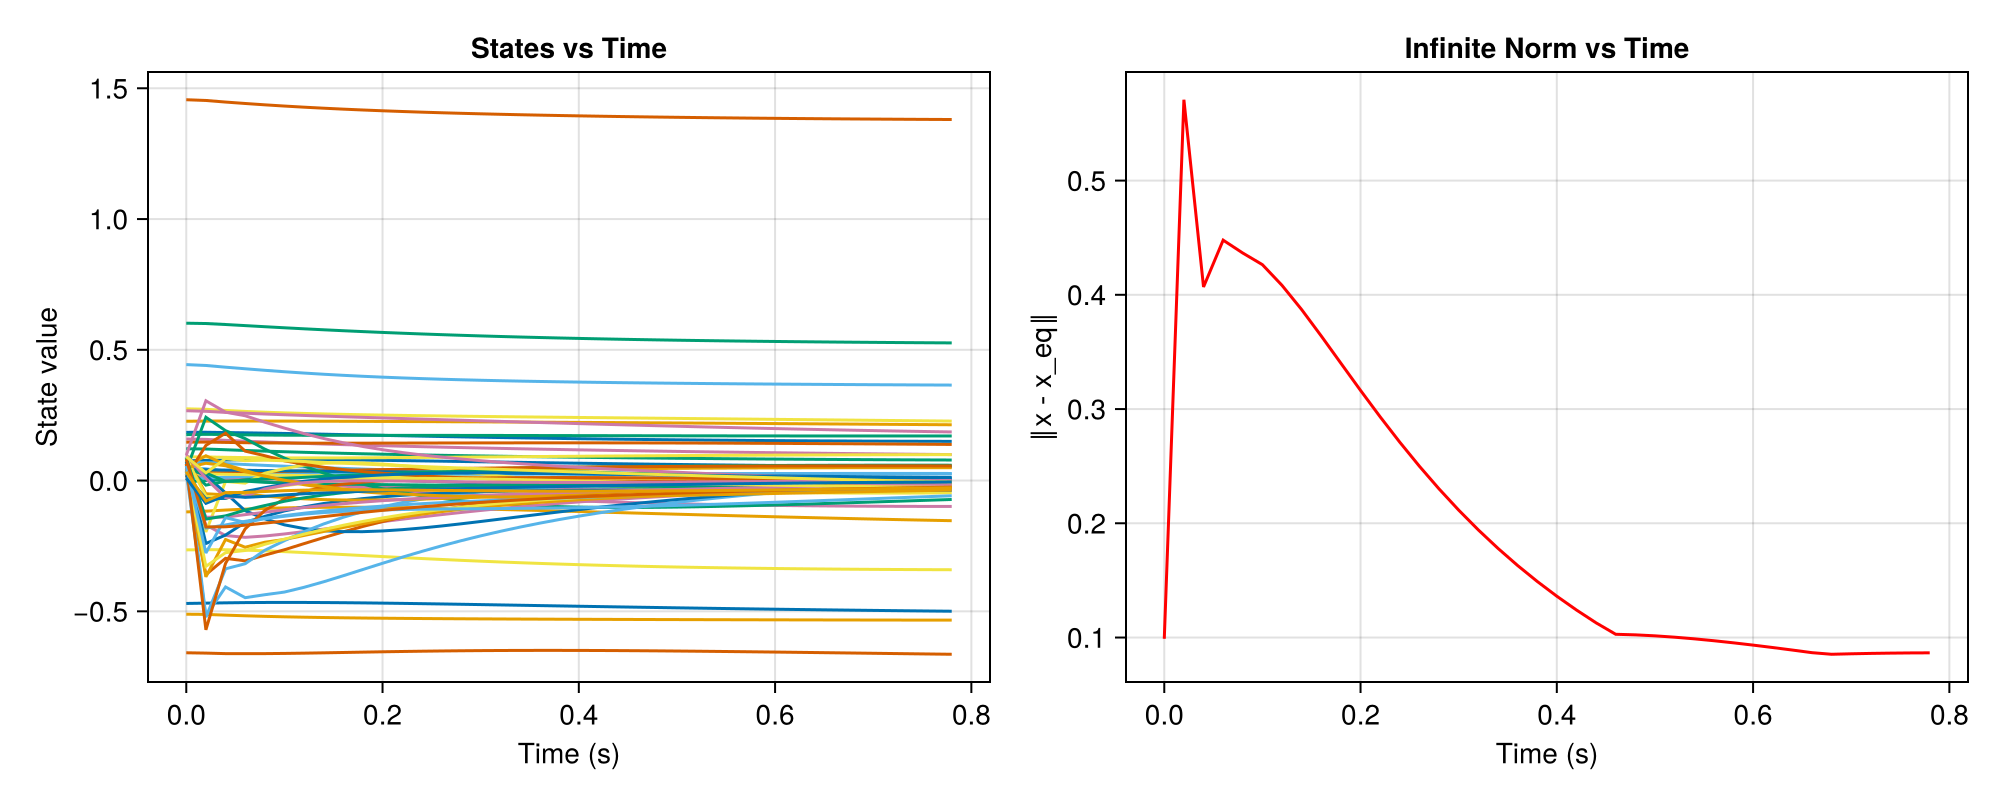

In [28]:
# Testing out LQR Results
model = G1Humanoid();
dt = 0.02
z = traj.datavec
nx = length(z[traj_indices.x[1]])
x0 = x_eq .+ 0.1 * rand(nx)
N = 40
X = [zeros(nx) for _ in 1:N]
X[1] = x0
for k = 1:N-1
    U = u_eq - Keq * (X[k] - x_eq)
    X[k+1] = rk4(model, X[k], U, dt) #.+ 1e-3 * rand(nx)
end

using CairoMakie, LinearAlgebra

# Time vector
t = 0:dt:dt*(N-1)

Xmat = hcat(X...)

l2norms = [norm(Xmat[:, k] - x_eq, Inf) for k in 1:N]

fig = Figure(resolution = (1000, 400))

ax1 = Axis(fig[1, 1], xlabel = "Time (s)", ylabel = "State value", title = "States vs Time")
for i in 1:size(Xmat, 1)
    lines!(ax1, t, Xmat[i, :], label = "x[$i]")
end

ax2 = Axis(fig[1, 2], xlabel = "Time (s)", ylabel = "‖x - x_eq‖", title = "Infinite Norm vs Time")
lines!(ax2, t, l2norms, color = :red)

fig


In [10]:
# Generate actual ball and humanoid trajectories
model = G1Humanoid();
dt = 0.02
N = length(traj_indices.x)
z = traj.datavec
nx = length(z[traj_indices.x[1]])
nu = length(z[traj_indices.u[1]])
balance_time = 50 
ball_flight_steps = 15 #ball_flight_steps
tot_time = balance_time + N + ball_flight_steps
nuh = length(u_eq) # humanoid input and states
nxh = length(x_eq)
nxb = 6 # ball state
Uh = [zeros(nu) for _ in 1:tot_time-1]
Xh = [zeros(nx) for _ in 1:tot_time]
Xb = [zeros(nxb) for _ in 1:tot_time] # 
Uh[1] = u_eq
Xh[1] = x_eq
Xb[1] = [0.2, -0.13, 0.11, 0, 0, 0] # position of center of ball

for k = 1:tot_time - 1
    if k <= balance_time
        Xb[k+1] = 1 * Xb[k] 
        Uh[k] = u_eq - Keq * (Xh[k] - x_eq)
        Xh[k+1] = rk4(model, Xh[k], Uh[k], dt) .+ 1e-3 * rand(nx)
    elseif k <= balance_time + N - 1
        Xb[k+1] = 1 * Xb[k]
        Uh[k] = z[traj_indices.u[k - balance_time]] - Ktv[k - balance_time] * (Xh[k] - z[traj_indices.x[k - balance_time]])
        Xh[k+1] = rk4(model, Xh[k], Uh[k], dt) .+ 1e-3 * rand(nx)
    elseif k == balance_time + N
        Uh[k] = 1 * u_g - Keq * (Xh[k] - x_eq)
        Xh[k+1] = rk4(model, Xh[k], Uh[k], dt)
        J = FD.jacobian(x_ -> get_right_foot_tip_location(model.mech, x_), z[traj_indices.x[k-balance_time]])
        dq = 1 * z[traj_indices.x[k - balance_time][30:58]]
        println(J[:, 1:29]*dq)
        Xb[k][4:6] .= J[:, 1:29]*dq
        Xb[k+1] = 1 * Xb[k]
        #Xb[k+1] .= ball_dynamics(Xb[k], dt)
    else
        Uh[k] = u_g - Kg * (Xh[k] - x_g)
        Xh[k+1] = rk4(model, Xh[k], Uh[k], dt) .+ 1e-3 * rand(nx)
        Xb[k+1] = ball_dynamics(Xb[k], dt)
    end
end

[7.142857144989616, 6.661338147750939e-16, 1.2753000003807358]


In [11]:
using MeshCatMechanisms 
animate_humanoid_kick(Xh, Xb, model, dt)

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("ball" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x61, 0x6c, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("left_ankle_roll_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_roll_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x6c, 0x6c, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_8" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x38], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_ankle_pitch_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x69, 0x74, 0x63, 0x68, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_ankle_pitch_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x74, 0x63, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_7" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_knee_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_knee_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6b, 0x6e, 0x65, 0x65, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "left_hip_yaw_link" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x5f, 0x79, 0x61, 0x77, 0x5f, 0x6c, 0x69, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_left_hip_yaw_